## Import necessary libraries

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# checking if GPU is available for training the network
device = torch.cuda.is_available()

if device:
  print("CUDA is available. Training on GPU...")
else:
  print("CUDA is not availabel. Training on CPU...")

CUDA is available. Training on GPU...


## Load the data

In [31]:
batch_size = 20

valid_size = 0.2

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(20),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_data = datasets.CIFAR10('data',train=True, transform=transform, download=True)
test_data = datasets.CIFAR10('data', train=False, transform=transform, download=True)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualising the images

In [32]:
%matplotlib inline

def imdisp(image):
  image = image/2 + 0.5 # removing normalisation
  plt.imshow(np.transpose(image,(1,2,0))) # converting from Tensor image

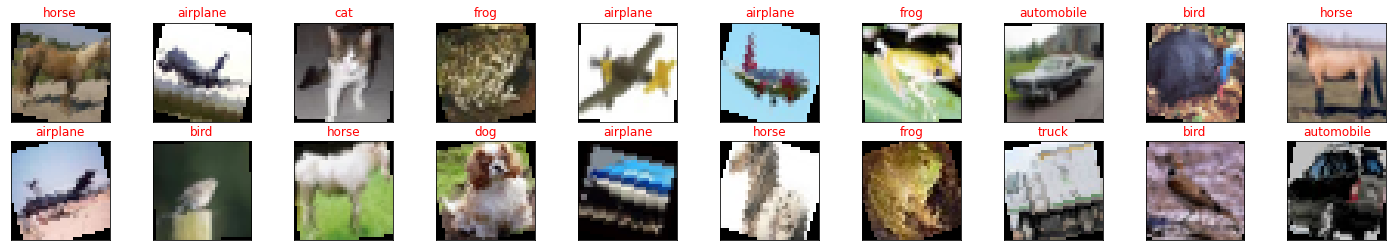

In [33]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imdisp(images[idx])
  ax.set_title(classes[labels[idx]],color='red')

#### Visualising in more detail

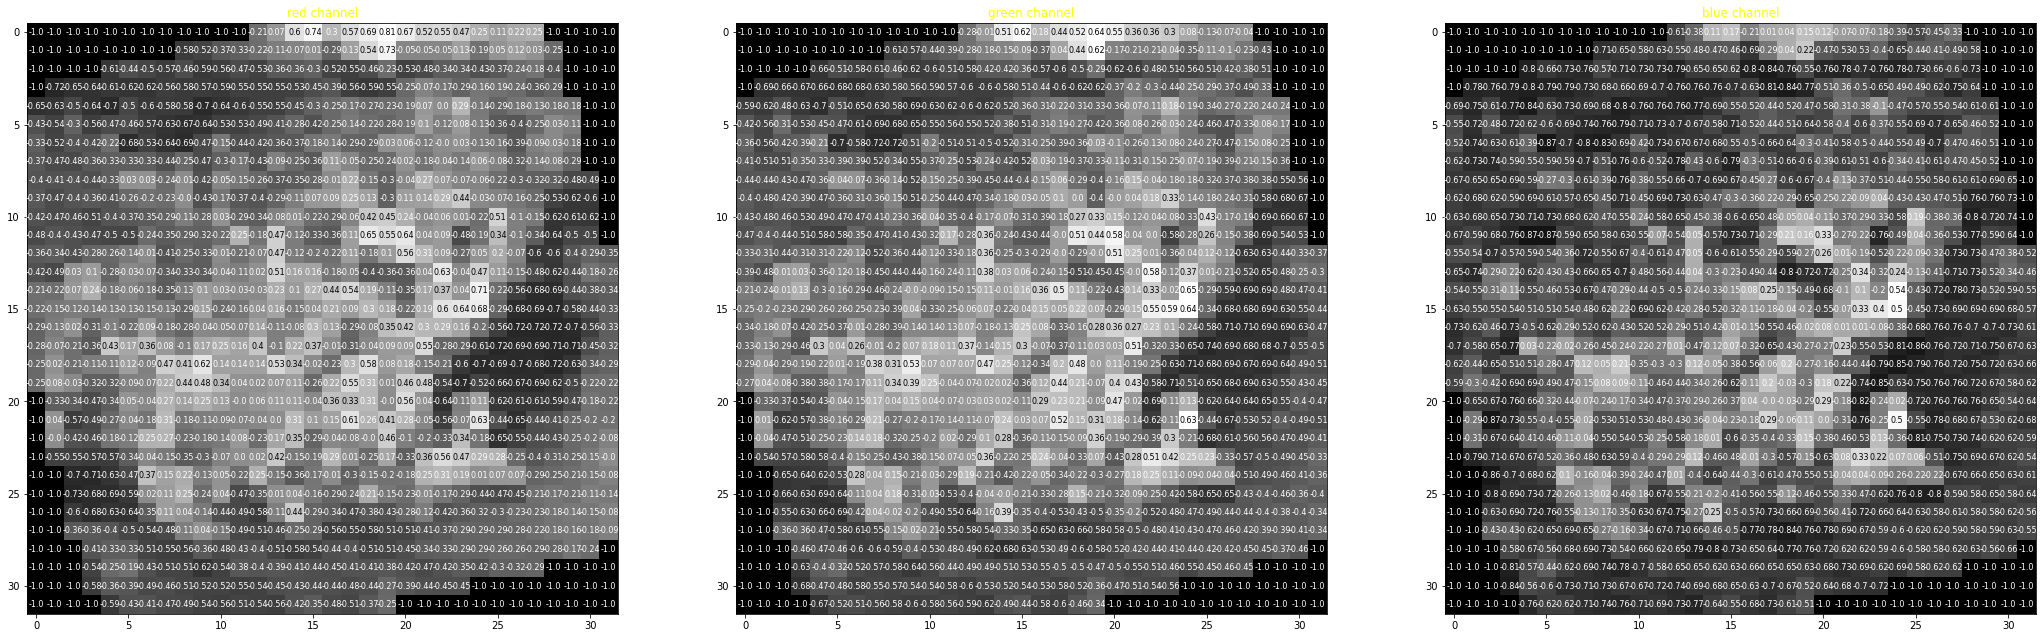

In [34]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx], color='yellow')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Defining the Network Architecture

In [42]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()

    # Defining the convolutional layers (3 in this case)
    # Conv. layer parameters: nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    # self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    # Defining the maxpool layer
    # layer parameters: nn.MaxPool2d(kernel_size, stride)
    self.pool = nn.MaxPool2d(2, 2)

    # Defining the fully connected layers
    self.fc1 = nn.Linear(64*4*4, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 10)

    # Defining dropout layer
    self.dropout = nn.Dropout(p=0.25)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    # x = self.pool(F.relu(self.conv4(x)))
    # print(x.shape)
    # Flatten the image
    x = x.view(-1, 64*4*4)

    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

model = Network()
print(model)

if device:
  model.cuda()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify the loss function and the optimiser

In [43]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train the Network

In [44]:
%%time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 20
valid_loss_min = np.Inf

for e in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0

  # Training the model
  model.train()
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    log_probs = model.forward(images)
    loss = criterion(log_probs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()*images.size(0)

    # Validating the model
  else:
    with torch.no_grad():
      
      model.eval()
      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        log_probs = model.forward(images)
        loss = criterion(log_probs, labels)

        valid_loss += loss.item()*images.size(0)


    model.train()
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)


    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(e+1, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
      print("Validation Loss decreased from {:.6f} to {:.6f}. Saving model...".format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.298598 	Validation Loss: 2.271576
Validation Loss decreased from inf to 2.271576. Saving model...
Epoch: 2 	Training Loss: 2.103512 	Validation Loss: 1.944993
Validation Loss decreased from 2.271576 to 1.944993. Saving model...
Epoch: 3 	Training Loss: 1.846128 	Validation Loss: 1.664005
Validation Loss decreased from 1.944993 to 1.664005. Saving model...
Epoch: 4 	Training Loss: 1.656766 	Validation Loss: 1.619362
Validation Loss decreased from 1.664005 to 1.619362. Saving model...
Epoch: 5 	Training Loss: 1.544735 	Validation Loss: 1.423748
Validation Loss decreased from 1.619362 to 1.423748. Saving model...
Epoch: 6 	Training Loss: 1.462363 	Validation Loss: 1.369983
Validation Loss decreased from 1.423748 to 1.369983. Saving model...
Epoch: 7 	Training Loss: 1.392535 	Validation Loss: 1.280719
Validation Loss decreased from 1.369983 to 1.280719. Saving model...
Epoch: 8 	Training Loss: 1.335246 	Validation Loss: 1.215460
Validation Loss decreased from 1.2

### Loading the best model

In [45]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

## Testing the model

In [46]:
device

device(type='cuda', index=0)

In [47]:
test_loss = 0.0
accuracy = 0.0
model.eval()

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    log_probs = model(images)
    batch_loss = criterion(log_probs, labels)

    test_loss += batch_loss.item()*images.size(0)

    probs = torch.exp(log_probs)

    top_p, top_class = probs.topk(1, dim=1)

    equals = top_class == labels.view(*top_class.shape)

    accuracy += torch.mean(equals.type(torch.FloatTensor))

model.train()

test_loss = test_loss/len(test_loader.sampler)

print("Test Loss: {:.6f} \tAccuracy: {:.6f}".format(test_loss, (accuracy/len(test_loader))*100))




Test Loss: 0.887188 	Accuracy: 69.049988
